<a href="https://colab.research.google.com/github/mvadrev/Tensorflow/blob/master/SEGNET2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=False)
 

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/My Drive/driveArea")
import tensorflow as tf
import cv2
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
with open("./images_3000_160.p", 'rb') as f:
  images = pickle.load(f)

with open("./labels_3000_160.p", 'rb') as f:
  labels = pickle.load(f)

print(len(labels))
print(len(images))
print(f)
print(type(labels))
print(type(images))

3000
3000
<_io.BufferedReader name='./labels_3000_160.p'>
<class 'list'>
<class 'list'>


In [ ]:
import numpy as np
new_labels = []
for label in labels:
  for i in range (label.shape[0]):
    for j in range (label.shape[1]):
      if(np.all(label[i][j] == [0,0,0])):
        label[i][j] = [0,1,0]
  new_labels.append(label)

 

   

         
   

In [ ]:
print(len(new_labels))

3000


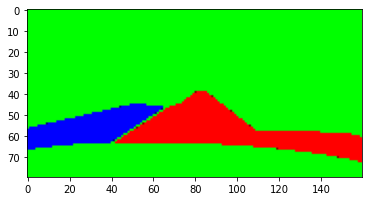

In [ ]:
plt.imshow(new_labels[3])

In [ ]:
flipped_labels = []
for i in range(len(new_labels)):
  flip = cv2.flip(labels[i],1)
  flipped_labels.append(flip)

In [ ]:
print(len(flipped_labels))
new_labels.extend(flipped_labels)
print(len(new_labels))

3000
6000


In [ ]:
flipped_images = []
for i in range(len(images)):
  flip = cv2.flip(images[i], 1)
  flipped_images.append(flip)


In [ ]:
print(len(flipped_images))
print(len(images))
images.extend(flipped_images)
print(len(images))

3000
3000
6000


In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
images = np.array(images)
nn_labels = np.array(new_labels) 
images,labels = shuffle(images, nn_labels)

x_train, x_val, y_train, y_val = train_test_split(images,labels,test_size=0.15)

n_train = len(x_train)
n_val = len(x_val)

In [ ]:
from tensorflow.python import keras
from tensorflow.python.keras import Sequential, Model
from tensorflow.python.keras.layers import Activation, Dropout, Conv2D, MaxPooling2D, Reshape, Input, add, UpSampling2D, Conv2DTranspose
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import regularizers


In [ ]:
def simple_encode_decoder():
  input_x = Input(shape=(80,160,3))
  x = BatchNormalization(input_shape=(80,160,3))(input_x)
  x = Conv2D(32,(3,3),padding='valid',strides=(1,1),activation='relu')(x)
  x1 = BatchNormalization()(x)
  x = Conv2D(32,(3,3),padding='valid',strides=(1,1),activation='relu')(x)
  x = MaxPooling2D((2,2),)(x1)
  x = UpSampling2D(interpolation='bilinear')(x)
  x = add([x1,x])
  x = Conv2DTranspose(32,(3,3),strides=(1,1), padding='valid', activation='relu')(x)
  x = Conv2D(3,(1,1),strides=(1,1), padding='valid',activation='softmax')(x)
  return Model(input_x,x)
  

model = simple_encode_decoder()
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 80, 160, 3)] 0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 80, 160, 3)   12          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 78, 158, 32)  896         batch_normalization_4[0][0]      
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 78, 158, 32)  128         conv2d_4[0][0]                   
_______________________________________________________________________________________

In [ ]:
import keras
batch_size = 16
epochs = 15
pool_size =(2,2)
learning_rate = 0.01
steps_per_epoch = len(x_train)/batch_size
input_shape = x_train.shape[1:]

datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(x_train)
optim = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optim, loss='categorical_crossentropy')
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),steps_per_epoch=steps_per_epoch, epochs=epochs, verbose =1, )

Epoch 1/15
319/318 [==============================] - 9s 30ms/step - loss: 0.3897
Epoch 2/15
319/318 [==============================] - 9s 29ms/step - loss: 0.3874
Epoch 3/15
319/318 [==============================] - 9s 30ms/step - loss: 0.3870
Epoch 4/15
319/318 [==============================] - 9s 29ms/step - loss: 0.3846
Epoch 5/15
319/318 [==============================] - 9s 29ms/step - loss: 0.3826
Epoch 6/15
319/318 [==============================] - 9s 29ms/step - loss: 0.3854
Epoch 7/15
319/318 [==============================] - 9s 29ms/step - loss: 0.3824
Epoch 8/15
319/318 [==============================] - 9s 29ms/step - loss: 0.3830
Epoch 9/15
319/318 [==============================] - 9s 29ms/step - loss: 0.3829
Epoch 10/15
319/318 [==============================] - 9s 29ms/step - loss: 0.3813
Epoch 11/15
319/318 [==============================] - 9s 29ms/step - loss: 0.3813
Epoch 12/15
319/318 [==============================] - 9s 29ms/step - loss: 0.3821
Epoch 13/15
3

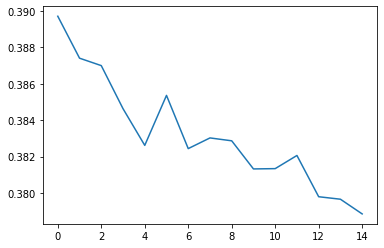

In [ ]:
model.save("model.h5")
plt.plot(history.history['loss'])

In [ ]:
def run(input_image):
  h, w , d = input_image.shape
  network_image = input_image.copy()
  network_image = cv2.resize(network_image,(160,80),interpolation=cv2.INTER_AREA)
  network_image = network_image[None,:,:,:]
  prediction = model.predict(network_image)[0]*255
  R,G,B = rgb_channel(prediction)
  blank = np.zeros_like(R).astype(np.uint8)
  lane_image = np.dstack((R,blank,B))
  lane_image = cv2.resize(lane_image,(w,h))
  result = cv2.addWeighted(input_image,1,lane_image.astype(np.uint8),1,0)
  return result

In [ ]:
def rgb_channel(img, thresholding=False,thres=230):
  image = np.copy(img)
  if thresholding:
    ret, image = cv2.threshold(image, thres, 255, cv2.THRESH_BINARY)
  R = image[:,:,0]
  G = image[:,:,1]
  B = image[:,:,2]
  return R,G,B

In [ ]:
result = plt.imread("./test.jpg")
res = run(result)


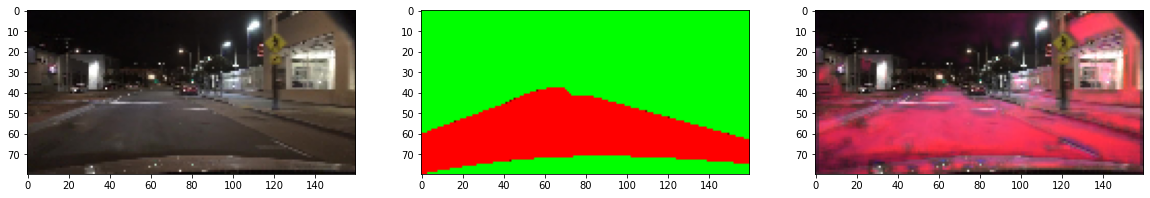

In [ ]:

import random
index = random.randint(0,len(images))
img_test = run(images[index])
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(images[index].squeeze())
ax2.imshow(labels[index].squeeze())
ax3.imshow(img_test)

